## **2. 시맨틱 세그멘테이션 데이터셋**

### **Sample Image 확인하기**

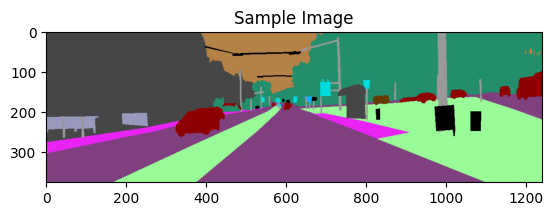

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

sample_img_path = os.path.expanduser("~/work/semantic_segmentation/data/training/semantic_rgb/000187_10.png")
sample_img = cv2.imread(sample_img_path)

plt.imshow(sample_img)
plt.title("Sample Image")
plt.show()

👉 학습용 라벨에서는 “픽셀 값(숫자)”이 라벨입니다.  
👉 색깔은 사람이 보기 쉽게 만든 시각화용 표현일 뿐입니다.

In [2]:
import numpy as np

label_path = os.path.expanduser(
    "~/work/semantic_segmentation/data/training/semantic/000187_10.png"
)

label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

print("shape:", label.shape)
print("dtype:", label.dtype)

unique_ids = np.unique(label)
print("Unique class IDs:", unique_ids)
print("Number of classes in this image:", len(unique_ids))

shape: (376, 1241)
dtype: uint8
Unique class IDs: [ 4  7  8 11 13 17 19 20 21 22 23 26 28]
Number of classes in this image: 13


In [3]:
y, x = 300, 600   # <- 도로 위라고 생각되는 좌표로 바꿔서 여러 번 찍어보기
print("class id at (y,x):", int(label[y, x]))

class id at (y,x): 7


### **데이터 로더(data loader) 만들기**

In [4]:
# !pip install albumentations

In [5]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import torch.nn as nn
import torch.optim as optim

print('=3')

=3


In [6]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

/tmp/ipykernel_11759/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


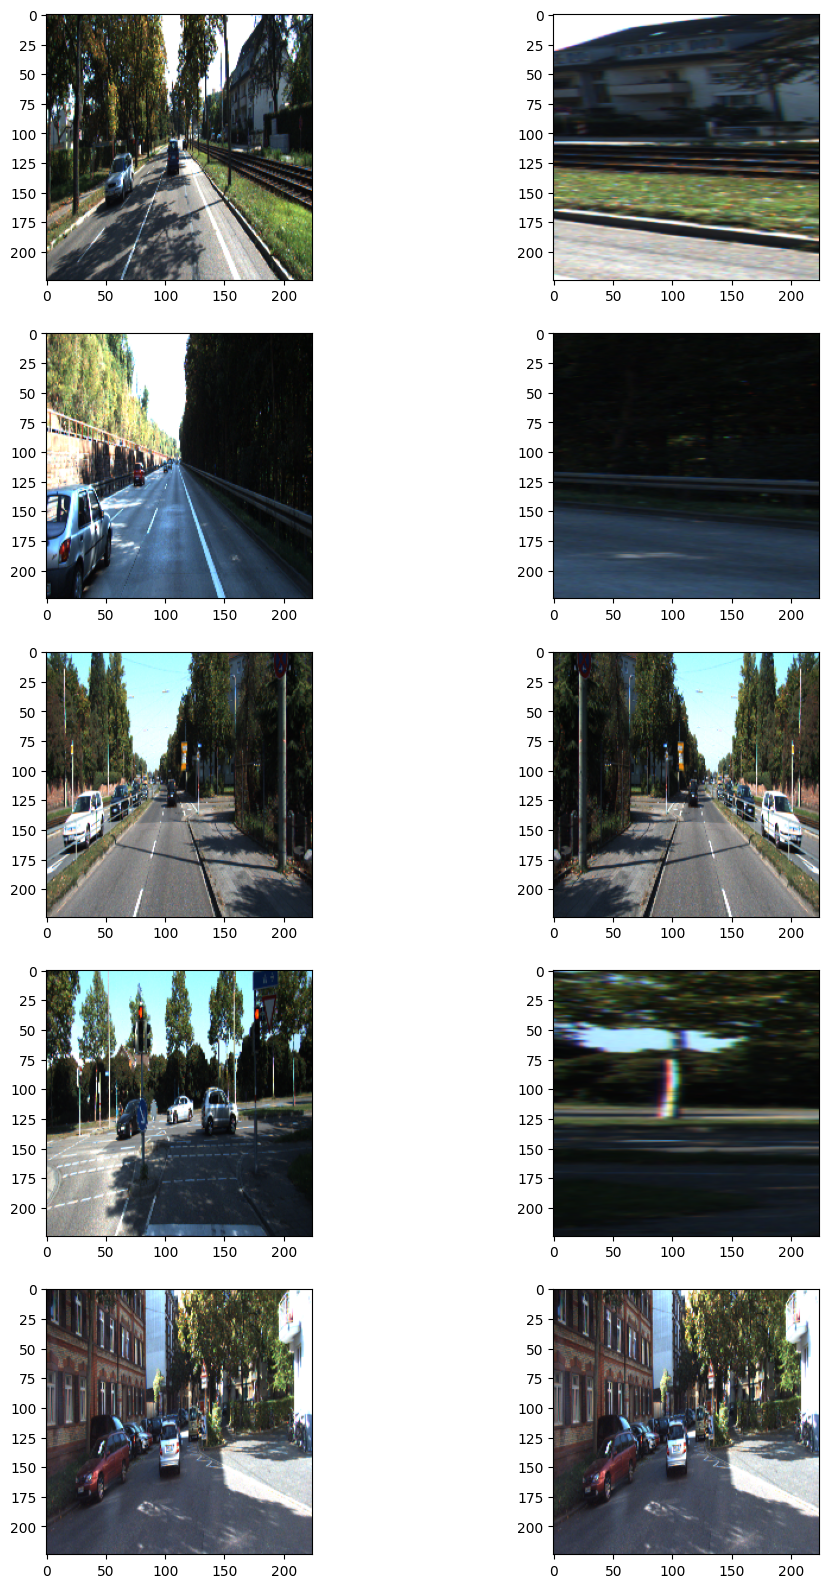

In [7]:
data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(data_dir, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [8]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [9]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/tmp/ipykernel_11759/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


## **3. 시맨틱 세그멘테이션 모델**

### **모델 구조 만들기**

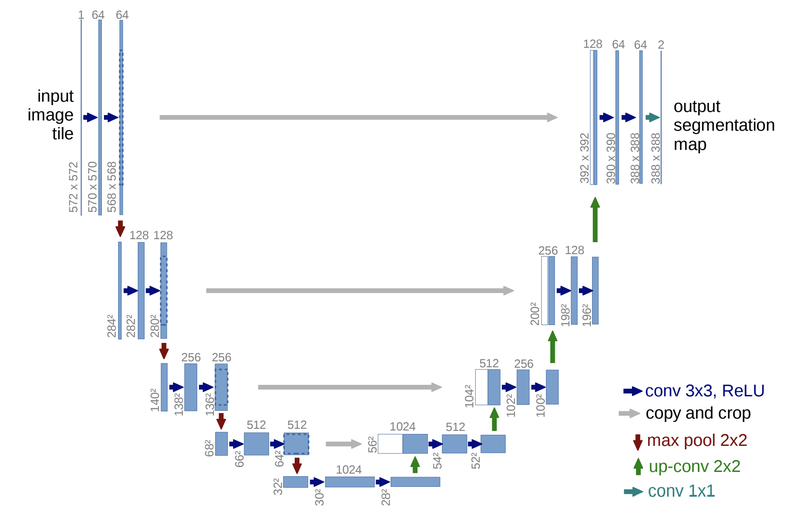

In [10]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

### **모델 학습하기**

In [14]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# -------------------------
# Validation 함수
# -------------------------
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            n_batches += 1

    return val_loss / n_batches


# -------------------------
# 학습 코드 (Val Loss 기준 Best 저장)
# -------------------------
def train_model(
    model_path,
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs = 100
):
    

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float("inf")
    best_epoch = -1
    
    for epoch in range(num_epochs):
    
        # ---- Train ----
        model.train()
        running_loss = 0.0
    
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float()
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        train_loss = running_loss / len(train_loader)
    
        # ---- Validation ----
        val_loss = validate(model, val_loader, criterion, device)
    
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")
    
        # ---- Best Model 저장 (Val Loss 기준) ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_path)
            print(f"  ✅ Best model saved! (Epoch {best_epoch}, Val Loss: {best_val_loss:.4f})")
    
    print(f"\nDone. Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.4f}")

In [15]:
%%time

model_path = "./seg_model_unet_best.pth"
model = UNet(input_channels=3, output_channels=1)

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(test_dataset,  batch_size=16, shuffle=False)

num_epochs = 100

train_model(model_path, model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch   1/100 | Train Loss: 0.6948 | Val Loss: 0.6825
  ✅ Best model saved! (Epoch 1, Val Loss: 0.6825)
Epoch   2/100 | Train Loss: 0.6548 | Val Loss: 0.5885
  ✅ Best model saved! (Epoch 2, Val Loss: 0.5885)
Epoch   3/100 | Train Loss: 0.5657 | Val Loss: 0.5638
  ✅ Best model saved! (Epoch 3, Val Loss: 0.5638)
Epoch   4/100 | Train Loss: 0.5032 | Val Loss: 0.4541
  ✅ Best model saved! (Epoch 4, Val Loss: 0.4541)
Epoch   5/100 | Train Loss: 0.4220 | Val Loss: 0.4084
  ✅ Best model saved! (Epoch 5, Val Loss: 0.4084)
Epoch   6/100 | Train Loss: 0.3606 | Val Loss: 0.3380
  ✅ Best model saved! (Epoch 6, Val Loss: 0.3380)
Epoch   7/100 | Train Loss: 0.3218 | Val Loss: 0.2938
  ✅ Best model saved! (Epoch 7, Val Loss: 0.2938)
Epoch   8/100 | Train Loss: 0.2600 | Val Loss: 0.3916
Epoch   9/100 | Train Loss: 0.2614 | Val Loss: 0.2691
  ✅ Best model saved! (Epoch 9, Val Loss: 0.2691)
Epoch  10/100 | Train Loss: 0.2466 | Val Loss: 0.3307
Epoch  11/100 | Train Loss: 0.2446 | Val Loss: 0.2979
Epoch 

## **4. 시맨틱 세그멘테이션 모델 시각화**

In [16]:
model_path = "./seg_model_unet_best.pth"

model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [17]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    # print(f"IoU : {iou_score:.6f}")
    return iou_score

In [29]:
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    # img_np = np.array(blended)

    # 시각화
    # plt.imshow(img_np)
    # plt.axis('off')  # 축 제거 (옵션)
    # plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

In [19]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/unet_result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

np.float64(0.7987598286722575)

## **5. UNetPlusPlus 모델 구현**

### **모델 구조 만들기**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetPlusPlus(nn.Module):
    """
    UNet++ (Nested U-Net)
    - base_channels: 첫 단계 채널 수(기본 64)
    - deep_supervision: True면 중간 출력들을 평균내서 사용(옵션)
    """
    def __init__(self, input_channels=3, output_channels=1, base_channels=64, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision

        nb = [base_channels, base_channels*2, base_channels*4, base_channels*8, base_channels*16]

        # --- Encoder blocks (j=0 column) ---
        self.conv0_0 = self.double_conv(input_channels, nb[0])
        self.conv1_0 = self.double_conv(nb[0], nb[1])
        self.conv2_0 = self.double_conv(nb[1], nb[2])
        self.conv3_0 = self.double_conv(nb[2], nb[3])
        self.conv4_0 = self.double_conv(nb[3], nb[4])

        self.pool = nn.MaxPool2d(2)

        # --- Upsample (ConvTranspose2d like your code) ---
        self.up1 = nn.ConvTranspose2d(nb[1], nb[0], 2, 2)
        self.up2 = nn.ConvTranspose2d(nb[2], nb[1], 2, 2)
        self.up3 = nn.ConvTranspose2d(nb[3], nb[2], 2, 2)
        self.up4 = nn.ConvTranspose2d(nb[4], nb[3], 2, 2)

        # --- Nested decoder convs ---
        # X(0,1): concat( X(0,0), up(X(1,0)) ) -> 64 + 64
        self.conv0_1 = self.double_conv(nb[0] + nb[0], nb[0])
        # X(1,1): 128 + 128
        self.conv1_1 = self.double_conv(nb[1] + nb[1], nb[1])
        # X(2,1): 256 + 256
        self.conv2_1 = self.double_conv(nb[2] + nb[2], nb[2])
        # X(3,1): 512 + 512
        self.conv3_1 = self.double_conv(nb[3] + nb[3], nb[3])

        # X(0,2): concat( X(0,0), X(0,1), up(X(1,1)) ) -> 64*3
        self.conv0_2 = self.double_conv(nb[0]*3, nb[0])
        # X(1,2): 128*3
        self.conv1_2 = self.double_conv(nb[1]*3, nb[1])
        # X(2,2): 256*3
        self.conv2_2 = self.double_conv(nb[2]*3, nb[2])

        # X(0,3): concat( X(0,0), X(0,1), X(0,2), up(X(1,2)) ) -> 64*4
        self.conv0_3 = self.double_conv(nb[0]*4, nb[0])
        # X(1,3): 128*4
        self.conv1_3 = self.double_conv(nb[1]*4, nb[1])

        # X(0,4): concat( X(0,0), X(0,1), X(0,2), X(0,3), up(X(1,3)) ) -> 64*5
        self.conv0_4 = self.double_conv(nb[0]*5, nb[0])

        # --- Output heads (deep supervision용) ---
        self.final1 = nn.Conv2d(nb[0], output_channels, kernel_size=1)
        self.final2 = nn.Conv2d(nb[0], output_channels, kernel_size=1)
        self.final3 = nn.Conv2d(nb[0], output_channels, kernel_size=1)
        self.final4 = nn.Conv2d(nb[0], output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder (j=0)
        x0_0 = self.conv0_0(x)                 # 1/1
        x1_0 = self.conv1_0(self.pool(x0_0))   # 1/2
        x2_0 = self.conv2_0(self.pool(x1_0))   # 1/4
        x3_0 = self.conv3_0(self.pool(x2_0))   # 1/8
        x4_0 = self.conv4_0(self.pool(x3_0))   # 1/16

        # j=1
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4(x4_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3(x3_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2(x2_0)], dim=1))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1(x1_0)], dim=1))

        # j=2
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3(x3_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2(x2_1)], dim=1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1(x1_1)], dim=1))

        # j=3
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2)], dim=1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1(x1_2)], dim=1))

        # j=4
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1(x1_3)], dim=1))

        if self.deep_supervision:
            # 중간 출력들을 모두 사용(학습 안정/성능 도움 될 때가 많음)
            out1 = self.final1(x0_1)
            out2 = self.final2(x0_2)
            out3 = self.final3(x0_3)
            out4 = self.final4(x0_4)
            out = (out1 + out2 + out3 + out4) / 4.0
            return torch.sigmoid(out)

        # 일반적으로 마지막 노드(x0_4)만 사용
        out = self.final4(x0_4)
        return torch.sigmoid(out)

### **모델 학습**

In [21]:
%%time

model_path = "./seg_model_unetplusplus_best.pth"
model = UNetPlusPlus(input_channels=3, output_channels=1)

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(test_dataset,  batch_size=16, shuffle=False)

num_epochs = 100

train_model(model_path, model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch   1/100 | Train Loss: 0.6548 | Val Loss: 0.6411
  ✅ Best model saved! (Epoch 1, Val Loss: 0.6411)
Epoch   2/100 | Train Loss: 0.5966 | Val Loss: 0.5755
  ✅ Best model saved! (Epoch 2, Val Loss: 0.5755)
Epoch   3/100 | Train Loss: 0.5745 | Val Loss: 0.5570
  ✅ Best model saved! (Epoch 3, Val Loss: 0.5570)
Epoch   4/100 | Train Loss: 0.5007 | Val Loss: 0.5137
  ✅ Best model saved! (Epoch 4, Val Loss: 0.5137)
Epoch   5/100 | Train Loss: 0.4282 | Val Loss: 0.4043
  ✅ Best model saved! (Epoch 5, Val Loss: 0.4043)
Epoch   6/100 | Train Loss: 0.3536 | Val Loss: 0.4100
Epoch   7/100 | Train Loss: 0.3034 | Val Loss: 0.3030
  ✅ Best model saved! (Epoch 7, Val Loss: 0.3030)
Epoch   8/100 | Train Loss: 0.3005 | Val Loss: 0.2974
  ✅ Best model saved! (Epoch 8, Val Loss: 0.2974)
Epoch   9/100 | Train Loss: 0.2657 | Val Loss: 0.2840
  ✅ Best model saved! (Epoch 9, Val Loss: 0.2840)
Epoch  10/100 | Train Loss: 0.2434 | Val Loss: 0.2836
  ✅ Best model saved! (Epoch 10, Val Loss: 0.2836)
Epoch  11

## **6. Unet++ 시맨틱 세그멘테이션 모델 시각화**

In [22]:
model_path = "./seg_model_unetplusplus_best.pth"

model = UNetPlusPlus(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNetPlusPlus(
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv4_0): Sequential(
    (0): Co

In [40]:
model_path = "./seg_model_unet_best.pth"

model_UNet_a = UNet(input_channels=3, output_channels=1)
model_UNet_a.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_UNet_a.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [42]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
output_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/result/unet_a")

score_list_unet_a = []
for i in range(170, 200):
    output, prediction, target = get_output(
         model_UNet_a,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=output_path + f'/unet_a_result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    
    score_list_unet_a.append(calculate_iou_score(target, prediction))

print("UNet_a 평균 IOU: ", sum(score_list_unet_a) / len(score_list_unet_a))

UNet_a 평균 IOU:  0.8003769357603844


In [43]:
model_path = "./seg_model_unetplusplus_best.pth"

model_UNetPlusPlus_a = UNetPlusPlus(input_channels=3, output_channels=1)
model_UNetPlusPlus_a.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_UNetPlusPlus_a.eval()  # 평가 모드로 전환

UNetPlusPlus(
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv4_0): Sequential(
    (0): Co

In [59]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
output_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/result/unetplusplus_a")

score_list_unetplusplus_a = []
for i in range(170, 200):
    output, prediction, target = get_output(
         model_UNetPlusPlus_a,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=output_path + f'/unetplusplus_a_result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    print(output)
    score_list_unetplusplus_a.append(calculate_iou_score(target, prediction))

print("UNetPlusPlus_a 평균 IOU: ", sum(score_list_unetplusplus_a) / len(score_list_unetplusplus_a))

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [255 255   0 ... 255 255 255]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[  0   0   0 ...   0   0   0]
 [  0   0

KeyboardInterrupt: 

In [53]:
from scipy.stats import ttest_rel
ttest_rel(score_list_unet_a, score_list_unetplusplus_a)

TtestResult(statistic=np.float64(-0.8472762932111837), pvalue=np.float64(0.40377962453009086), df=np.int64(29))

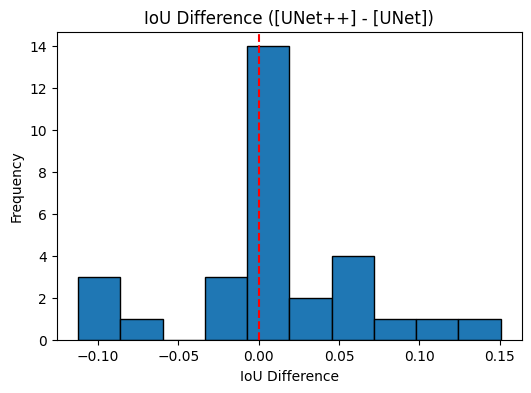

In [57]:
import matplotlib.pyplot as plt

diff = np.array(score_list_unetplusplus_a) - np.array(score_list_unet_a)

plt.figure(figsize=(6,4))
plt.hist(diff, bins=10, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')  # 0 기준선
plt.title("IoU Difference ([UNet++] - [UNet])")
plt.xlabel("IoU Difference")
plt.ylabel("Frequency")
plt.show()

## **7. Unet VS Unet++ 중간 성능 비교**

### **결과 표**
| Model    | Val Loss | Val 데이터 평균 IoU |
|----------|----------|----------|
| UNet     | 0.1565   | 80.04%   |
| UNet++   | 0.1359   | 80.94%   |  

<br>

### **결과 및 해석**
  - Validation 데이터(30장)에 대해 두 모델의 IoU를 비교함
  - 30개 중 21개 이미지에서 UNet++의 IoU가 더 높게 나타남
  - 그러나 paired t-test 결과 p-value = 0.40으로, 통계적으로 유의미한 차이는 확인되지 않음
  - 따라서 UNet++이 약한 개선 경향을 보이기는 하지만, 현재 데이터 규모에서는 UNet보다 확실히 우수하다고 결론 내리기에는 근거가 부족함  

<br>

### **큰 차이가 나지 않는 이유?**
- UNet++는 더 복잡하므로 작은 데이터에서는 overfitting 위험 증가
- UNet++는 파라미터가 더 많아서 최적 수렴점이 다를 수 있음

<br>

### **추가 실험**
#### **실험1**
- testing 폴더 내의 200개 사진도 학습에 활용
  - testing 폴더 내의 파일은 라벨이 없어서 평가에는 못 쓰지만, 학습에는 활용할 수 있음
- Pseudo-label (Self-training)
  - unlabeled된 200장 데이터를 학습에 활용
  - 학습시킨 Unet++에 200장 데이터를 넣어서 라벨을 생성하고 Training 포함시켜보기 
#### **실험2**
- IoU를 증가시킬 목적이라면, 도로 주행 중 불필요할 수 있는 양옆, 위쪽 영역을 제외하고 IoU 계산해보기

## **실험1**

In [109]:
def get_output_test(model, preproc, image_path, label_path, output_path):
    from PIL import Image
    
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        
    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    # 0 또는 1로 변환
    pred_np = np.array(prediction)          # 0 or 255
    pred_bin = (pred_np > 0).astype(np.uint8)   # 0 or 1

    # 원본 사이즈로 변환
    pred_pil = Image.fromarray(pred_bin)

    pred_resized = pred_pil.resize(
        (origin_img.shape[1], origin_img.shape[0]),  # (W, H)
        resample=Image.NEAREST
    )

    # 0 or 7(도)로 변환
    pred_resized_np = np.array(pred_resized)   # 0 or 1
    pred_07 = pred_resized_np * 7              # 0 or 7

    # PNG로 저장
    pred_07 = pred_07.astype(np.uint8)
    Image.fromarray(pred_07).save(label_path)

    # 눈으로 확인하기 위해 RGB 이미지로 저장
    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)
    blended.save(output_path)

In [100]:
model_path = "./seg_model_unetplusplus_best.pth"

model_UNetPlusPlus_a = UNetPlusPlus(input_channels=3, output_channels=1)
model_UNetPlusPlus_a.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_UNetPlusPlus_a.eval()  # 평가 모드로 전환

UNetPlusPlus(
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv4_0): Sequential(
    (0): Co

In [111]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/testing_pseudo")

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.

for i in range(200):
    get_output_test(
         model_UNetPlusPlus_a,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'/semantic_rgb/00{str(i).zfill(4)}_10.png'
     )

/tmp/ipykernel_11759/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


#### **데이터 로더 재정의**

In [115]:
from torch.utils.data import ConcatDataset, DataLoader

data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
data_dir_b = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/testing_pseudo")

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

# Training 데이터 170개
train_dataset_a = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

# Testing 데이터 200개
train_dataset_b = KittiDataset(
    data_dir_b,
    augmentation=augmentation,
    is_train=True
) 

train_dataset = ConcatDataset([train_dataset_a, train_dataset_b])

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/tmp/ipykernel_11759/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


In [116]:
%%time

model_path = "./seg_model_unet_b_best.pth"
model = UNet(input_channels=3, output_channels=1)

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100

train_model(model_path, model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch   1/100 | Train Loss: 0.6327 | Val Loss: 0.5745
  ✅ Best model saved! (Epoch 1, Val Loss: 0.5745)
Epoch   2/100 | Train Loss: 0.5095 | Val Loss: 0.4055
  ✅ Best model saved! (Epoch 2, Val Loss: 0.4055)
Epoch   3/100 | Train Loss: 0.3352 | Val Loss: 0.2881
  ✅ Best model saved! (Epoch 3, Val Loss: 0.2881)
Epoch   4/100 | Train Loss: 0.3147 | Val Loss: 0.3049
Epoch   5/100 | Train Loss: 0.2494 | Val Loss: 0.2501
  ✅ Best model saved! (Epoch 5, Val Loss: 0.2501)
Epoch   6/100 | Train Loss: 0.2201 | Val Loss: 0.3134
Epoch   7/100 | Train Loss: 0.2188 | Val Loss: 0.2858
Epoch   8/100 | Train Loss: 0.1853 | Val Loss: 0.2086
  ✅ Best model saved! (Epoch 8, Val Loss: 0.2086)
Epoch   9/100 | Train Loss: 0.1851 | Val Loss: 0.3389
Epoch  10/100 | Train Loss: 0.1574 | Val Loss: 0.2795
Epoch  11/100 | Train Loss: 0.1615 | Val Loss: 0.2457
Epoch  12/100 | Train Loss: 0.1548 | Val Loss: 0.2851
Epoch  13/100 | Train Loss: 0.1688 | Val Loss: 0.2305
Epoch  14/100 | Train Loss: 0.1410 | Val Loss: 0

In [117]:
%%time

model_path = "./seg_model_unetplusplus_b_best.pth"
model = UNetPlusPlus(input_channels=3, output_channels=1)

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(test_dataset,  batch_size=16, shuffle=False)

num_epochs = 100

train_model(model_path, model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch   1/100 | Train Loss: 0.6616 | Val Loss: 0.5733
  ✅ Best model saved! (Epoch 1, Val Loss: 0.5733)
Epoch   2/100 | Train Loss: 0.5560 | Val Loss: 0.5511
  ✅ Best model saved! (Epoch 2, Val Loss: 0.5511)
Epoch   3/100 | Train Loss: 0.4456 | Val Loss: 0.4839
  ✅ Best model saved! (Epoch 3, Val Loss: 0.4839)
Epoch   4/100 | Train Loss: 0.3543 | Val Loss: 0.2643
  ✅ Best model saved! (Epoch 4, Val Loss: 0.2643)
Epoch   5/100 | Train Loss: 0.2282 | Val Loss: 0.2529
  ✅ Best model saved! (Epoch 5, Val Loss: 0.2529)
Epoch   6/100 | Train Loss: 0.1997 | Val Loss: 0.2479
  ✅ Best model saved! (Epoch 6, Val Loss: 0.2479)
Epoch   7/100 | Train Loss: 0.1808 | Val Loss: 0.3075
Epoch   8/100 | Train Loss: 0.1747 | Val Loss: 0.2043
  ✅ Best model saved! (Epoch 8, Val Loss: 0.2043)
Epoch   9/100 | Train Loss: 0.1759 | Val Loss: 0.2204
Epoch  10/100 | Train Loss: 0.1554 | Val Loss: 0.2927
Epoch  11/100 | Train Loss: 0.1509 | Val Loss: 0.2167
Epoch  12/100 | Train Loss: 0.1498 | Val Loss: 0.2447
Ep

In [121]:
model_path = "./seg_model_unet_b_best.pth"

model_UNet_b = UNet(input_channels=3, output_channels=1)
model_UNet_b.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_UNet_b.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [123]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
output_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/result/unet_b")

score_list_unet_b = []
for i in range(170, 200):
    output, prediction, target = get_output(
         model_UNet_b,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=output_path + f'/unet_b_result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    
    score_list_unet_b.append(calculate_iou_score(target, prediction))

print("UNet_b 평균 IOU: ", sum(score_list_unet_b) / len(score_list_unet_b))

UNet_b 평균 IOU:  0.816488864289193


In [124]:
model_path = "./seg_model_unetplusplus_b_best.pth"

model_UNetPlusPlus_b = UNetPlusPlus(input_channels=3, output_channels=1)
model_UNetPlusPlus_b.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_UNetPlusPlus_b.eval()  # 평가 모드로 전환

UNetPlusPlus(
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv4_0): Sequential(
    (0): Co

In [126]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
output_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/result/unetplusplus_b")

score_list_unetplusplus_b = []
for i in range(170, 200):
    output, prediction, target = get_output(
         model_UNetPlusPlus_b,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=output_path + f'/unetplusplus_b_result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    score_list_unetplusplus_b.append(calculate_iou_score(target, prediction))

print("UNetPlusPlus_b 평균 IOU: ", sum(score_list_unetplusplus_b) / len(score_list_unetplusplus_b))

UNetPlusPlus_b 평균 IOU:  0.8228239683172115


In [127]:
from scipy.stats import ttest_rel
ttest_rel(score_list_unet_b, score_list_unetplusplus_b)

TtestResult(statistic=np.float64(-0.4774399557718631), pvalue=np.float64(0.6366276893191525), df=np.int64(29))

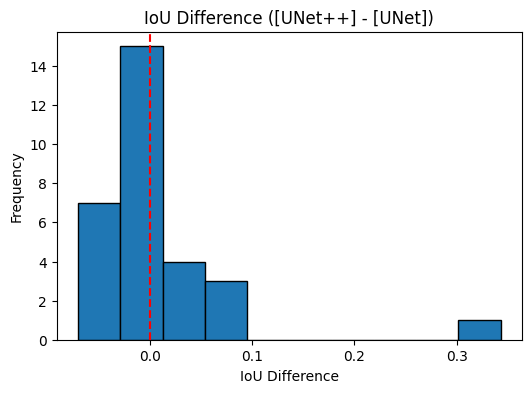

In [128]:
import matplotlib.pyplot as plt

diff = np.array(score_list_unetplusplus_b) - np.array(score_list_unet_b)

plt.figure(figsize=(6,4))
plt.hist(diff, bins=10, edgecolor='black')
plt.axvline(0, color='red', linestyle='--')  # 0 기준선
plt.title("IoU Difference ([UNet++] - [UNet])")
plt.xlabel("IoU Difference")
plt.ylabel("Frequency")
plt.show()

## **실험2**

In [131]:
import numpy as np
from skimage.transform import resize

def calculate_iou_score_roi(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(
            prediction,
            target.shape,
            mode='constant',
            preserve_range=True
        ).astype(np.uint8)

    H, W = target.shape

    # ---- ROI 영역 계산 ----
    top_cut = int(H * (1/3))
    left_cut = int(W * (1/6))
    right_cut = int(W * (5/6))

    # ROI 슬라이싱
    target_roi = target[top_cut:, left_cut:right_cut]
    pred_roi = prediction[top_cut:, left_cut:right_cut]

    # ---- IoU 계산 ----
    intersection = np.logical_and(target_roi, pred_roi).sum()
    union = np.logical_or(target_roi, pred_roi).sum()

    iou_score = intersection / (union + 1e-7)

    return float(iou_score)

In [136]:

dir_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")
output_path = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/result/unetplusplus_c")

score_list_unetplusplus_c = []
for i in range(170, 200):
    output, prediction, target = get_output(
         model_UNetPlusPlus_b,
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=output_path + f'/unetplusplus_c_result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    score_list_unetplusplus_c.append(calculate_iou_score_roi(target, prediction))

print("UNetPlusPlus_c 평균 IOU: ", sum(score_list_unetplusplus_c) / len(score_list_unetplusplus_c))

UNetPlusPlus_c 평균 IOU:  0.8449652772742708


## **결과**

### **결과 표**
| No.      | 분류      | Model    | Data(Train / Val)    | Val Loss | Val 데이터에 대한 평균 IoU  |
|-----------|-----------|----------|----------------------|----------|----------------------------|
| 1 | 기본 모델 | UNet     | 170 / 30             | 0.1565   | 80.04%                     |
| 2 | 기본 모델 | UNet++   | 170 / 30             | 0.1359   | 80.94%                     |
| 3 | 실험1     | UNet     | 370 / 30             | 0.1385   | 81.65%                     | 
| 4 | 실험1     | UNet++   | 370 / 30             | 0.1302   | 82.28%                     | 
| 5 | 실험2     | UNet++   | 370 / 30             | 0.1302   | 84.50%                     |

<br>

### 모델 별 결과 샘플 이미지
0. 라벨 이미지  
   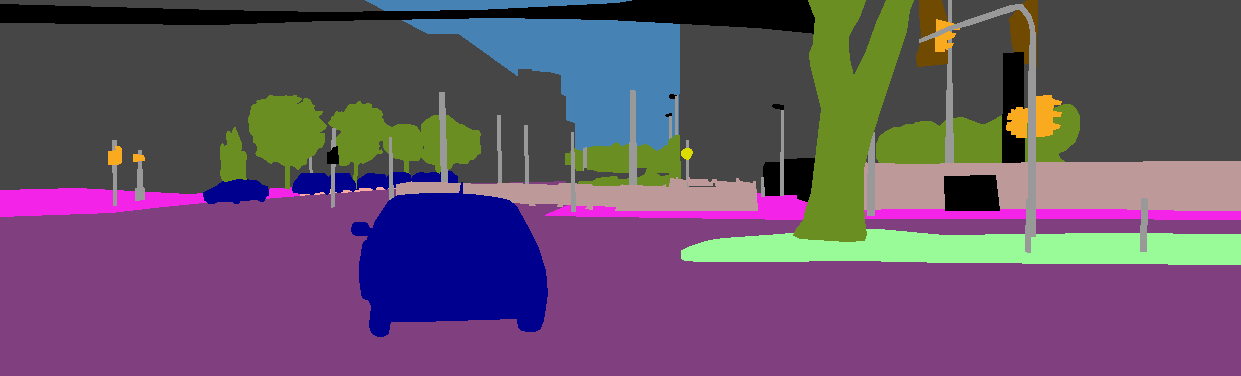   
1. 기본모델 / Unet  
   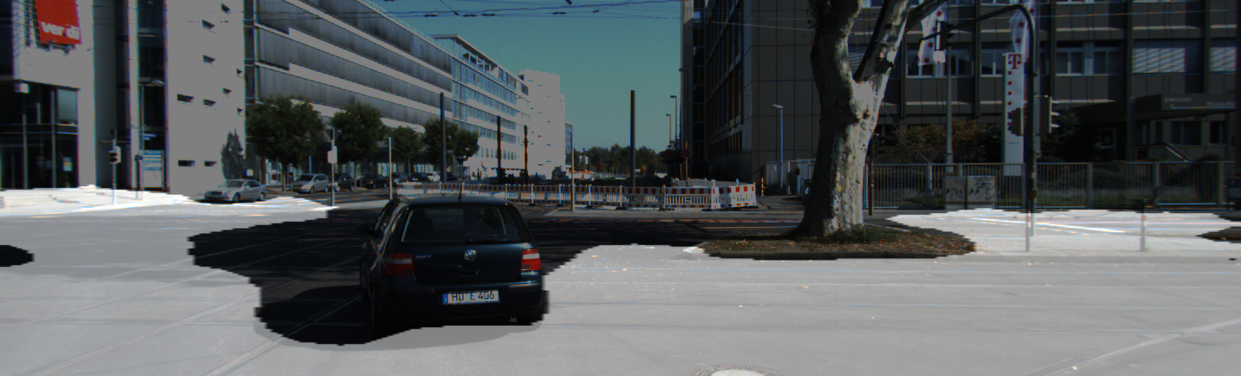
2. 기본모델 / Unet++  
   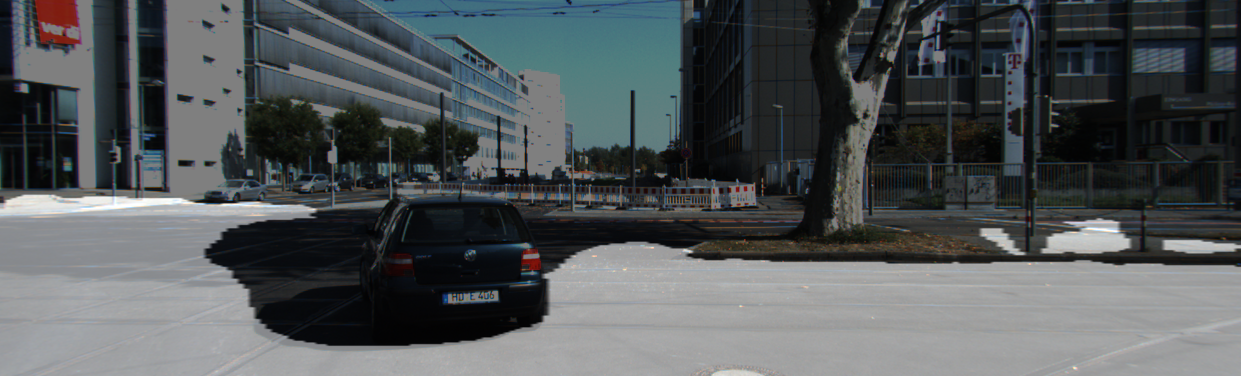
3. 실험1 / Unet  
   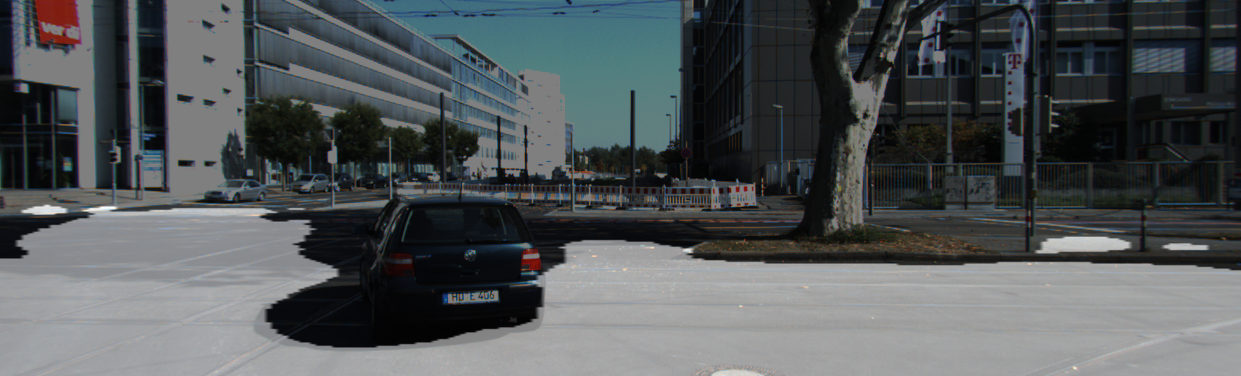
4. 실험1 / Unet++  
   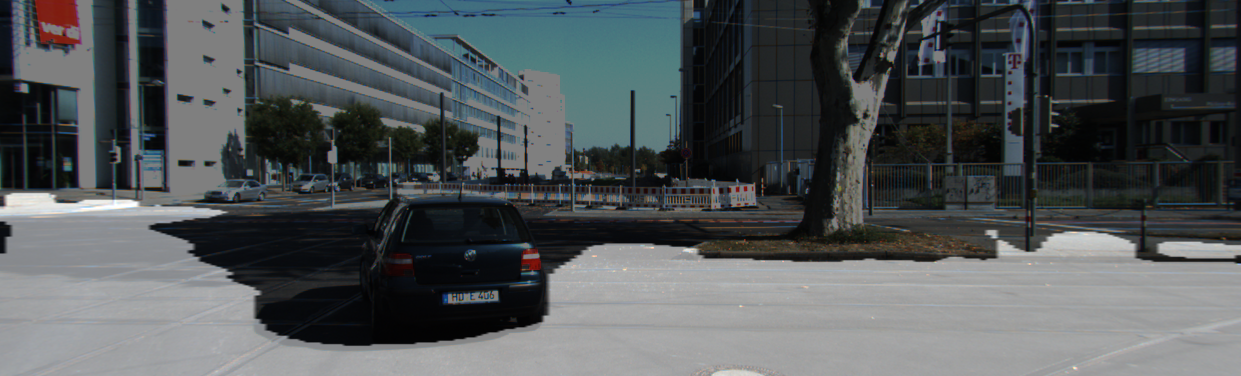   

### **결과 및 해석**
#### **실험1**
- 두 모델 모두 Val Loss가 줄어든 것을 보면, pseudo-label이 실제로 학습에 도움이 되었음을 보여줌
- UNet++이 일관되게 약간 더 좋음
- 단, pvalue를 계산해보면 구조에 의한 유의미한 차이는 없는 것으로 보임
  - Validation이 30장 뿐이라 표본 수가 적은 게 원인일듯
  - Pseudo-label이 모든 이미지에 고르게 도움을 준 건 아
- 현 수준에서는 구조 차이보다는 데이터 증가 효과가 더 지배적인

#### **실험2**
- 위쪽 1/3, 양옆 1/6을 제외하고 IoU 계산
- 가장 높은 IoU를 보여줌
- 그러나 평가 기준을 완화한 것이기 때문에 성능 향상이라기보다 평가 조건 변경에 따른 상승임
- 기술 요구사항이 '근거리 주행영역 정확도'라면 충분히 타당한 평가/최적화 방향이 될 수 있을듯 

<br>

### **향후 개선 사항**
- 데이터 더 늘려보기
- threshold 튜닝 : 0.5 고정 대신, validation에서 IoU가 최대가 되는 threshold를 찾기
- 클래스 불균형 대응 : 도로 픽셀이 적으면 BCE가 배경 쪽으로 치우치기 쉬움

## **회고**
- 모델 구조 변경에 따른 성능 향상은 제한적이었으며, 데이터 증가가 더 큰 영향을 미쳤음을 확인하였음
- Pseudo-label을 활용한 데이터 확장으로 학습 및 평균 IoU가 상승하는 경향을 확인
- 기회가 되면 IoU에 대한 threshold를 조절하는 방법도 해보고싶음
- 좀 아쉬운 점은 전체 데이터에 대해서 클래스 분포를 살펴보고, '도로' 클래스에 대한 데이터 증강에 더 힘썼으면 좋은 결과가 나오지 않았을까 생각함